# Bayesian state space approach for nonsynchronous trading

Previously we have mentioned the problem of nonsynchronous trading and some of its aspects, such as the bid-ask bounce. When we have a long time series with daily frequency, this does not have much of an impact, however in higher frequencies, e.g., minute by minute, this can be an issue.

We will first look at a 1-minute frequency series of the price (and also returns) of a stock with lower trading volume.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
import seaborn as sns
import yfinance as yf
import pymc as pm
import arviz as az
%matplotlib inline

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
pd.Timestamp.today() - pd.tseries.offsets.BDay(1)

Timestamp('2024-01-10 14:00:07.750461')

In [3]:
today_date = pd.to_datetime('today').strftime("%Y-%m-%d")
last_bday = (pd.Timestamp.today() - pd.tseries.offsets.BDay(1)).strftime("%Y-%m-%d")
morn_price = yf.Ticker("MORN").history(start = last_bday, end = today_date, interval="1m")["Close"]

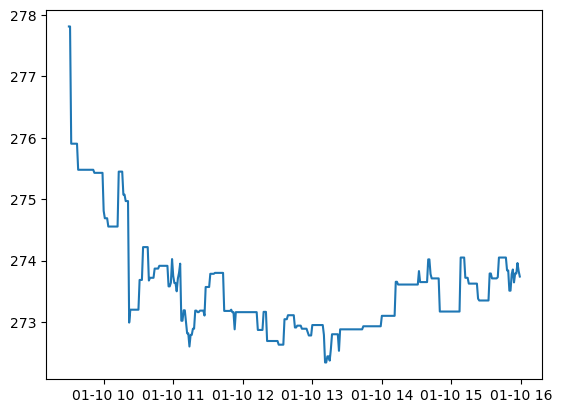

In [4]:
morn_price_full = morn_price.asfreq("T", method='pad')
plt.plot(morn_price_full)

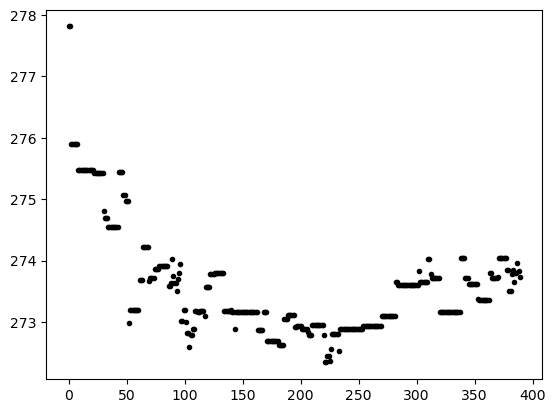

In [5]:
plt.plot(morn_price_full.values, "ok", ms=3, alpha=1.0, label="observed data")

<Axes: xlabel='Datetime'>

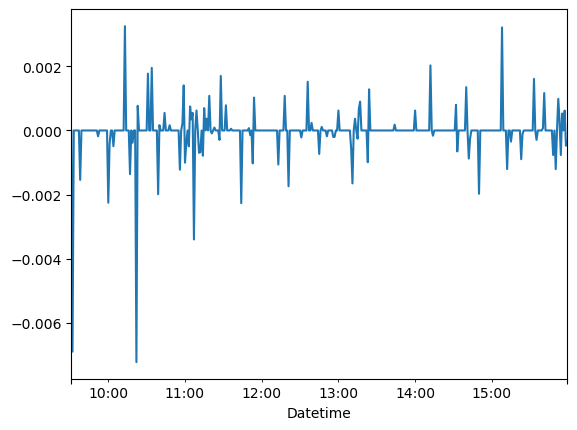

In [6]:
returns = morn_price_full.apply(np.log).diff().dropna()
returns.plot()

You can see that the stock does not trade at many given minutes. This is reflected in the returns series, where it is equal to zero at many periods. That means that we have to deal with the issue of missing data.

This is where we introduce *Gaussian processes*, which is a Bayesian approach for latent variable regression. A state space model with the latent variable as a Gaussian process can be written as

$y_t = f(x_t) + \varepsilon_t$,

$f(x) \sim GP(m(x), k(x,x'))$,

where $m(x)$ is a mean function and $k(x,x')$ is a covariance function between points $x$ and $x'$ of the latent variable.

Gaussian processes are a type of nonparametric model. Nonparametric models are named like that because they do not have a fixed number of parameters, and instead allow for flexibility letting the number of parameters vary with the data. This is advantageous in our case because we have unevenly observed data, with irregular intervals between observations. In the case of Gaussian processes, the estimated latent variable is the function $f(x)$, which can be evaluated for any value of $x$, including at time periods where we did not have an observation for $y_t$.

Now, let's look at the functions $m(x)$ and $k(x,x')$. The first one is a mean function that is generally set to zero or a constant level. The other, $K(x,x')$ is a covariance function between points $x$ and $x'$. Note that there is no fixed length between $x$ and $x'$, but the value of $K$ changes as the distance between both points grow. 

One example of covariance function for Gaussian processes is the exponentiated quadratic function:

$k(x, x') = \eta^2 * \mathrm{exp}\left[ -\frac{(x - x')^2}{2 \ell^2} \right]$,

where $\eta$ and $\ell$ are parameters. We can see that the covariance is a function of the distance $(x - x')^2$, increasing as the distance shortens. 

Another covariance function is the exponential function

$k(x, x') = \mathrm{exp}\left[ -\frac{||x - x'||}{2\ell^2} \right]$,

which is not a function of the quadratic deviation $(x - x')^2$ but of the absolute deviation $||x - x'||$.

We also have the Matérn 3/2 function:

$k(x, x') = \left(1 + \frac{\sqrt{3(x - x')^2}}{\ell}\right)\mathrm{exp}\left[ - \frac{\sqrt{3(x - x')^2}}{\ell} \right]$

A complete list of Gaussian process covariance functions can be found in: https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MeansAndCovs.html

We can then choose one of the functions to be the prior covariance function for our Gaussian process. For our example, let's use the Matérn 3/2

In [7]:
lin_sp = np.linspace(0, 10, len(returns))
lin_df = pd.Series(lin_sp, index=returns.index, name="lin_sp")
X = np.insert(pd.concat([lin_df, morn_price], axis=1).dropna()['lin_sp'].values, 0, 0)[:, None]

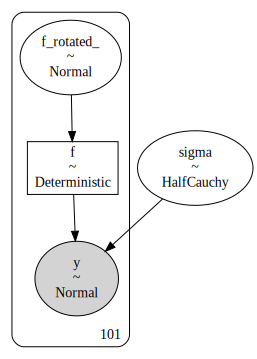

In [8]:
with pm.Model() as gp_model:
    mean_f = pm.gp.mean.Constant(np.mean(morn_price.values))
    lengthscale = 1
    cov = 2 * pm.gp.cov.Matern32(1, lengthscale)
    gp = pm.gp.Latent(mean_func = mean_f, cov_func=cov)

    f = gp.prior("f", X=X)

    obs_noise = pm.HalfCauchy("sigma", beta = 1)
    y = pm.Normal("y", mu = f, sigma = obs_noise, observed = morn_price.values)
pm.model_to_graphviz(gp_model)

In [9]:
with gp_model:
    trace_gp = pm.sample(5000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [f_rotated_, sigma]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 2502 seconds.


In [10]:
gp_median = np.median(trace_gp.posterior['f'].values, axis=(0,1)) # median across chains and draws 
gp_hdi_lower = az.hdi(trace_gp, hdi_prob=.95)['f'].T[0].values
gp_hdi_upper = az.hdi(trace_gp, hdi_prob=.95)['f'].T[1].values

In [11]:
morn_price.index.strftime("%H:%M")

Index(['09:30', '09:32', '09:38', '09:52', '10:00', '10:01', '10:04', '10:13',
       '10:17', '10:19',
       ...
       '15:42', '15:48', '15:50', '15:52', '15:53', '15:54', '15:55', '15:57',
       '15:58', '15:59'],
      dtype='object', name='Datetime', length=101)

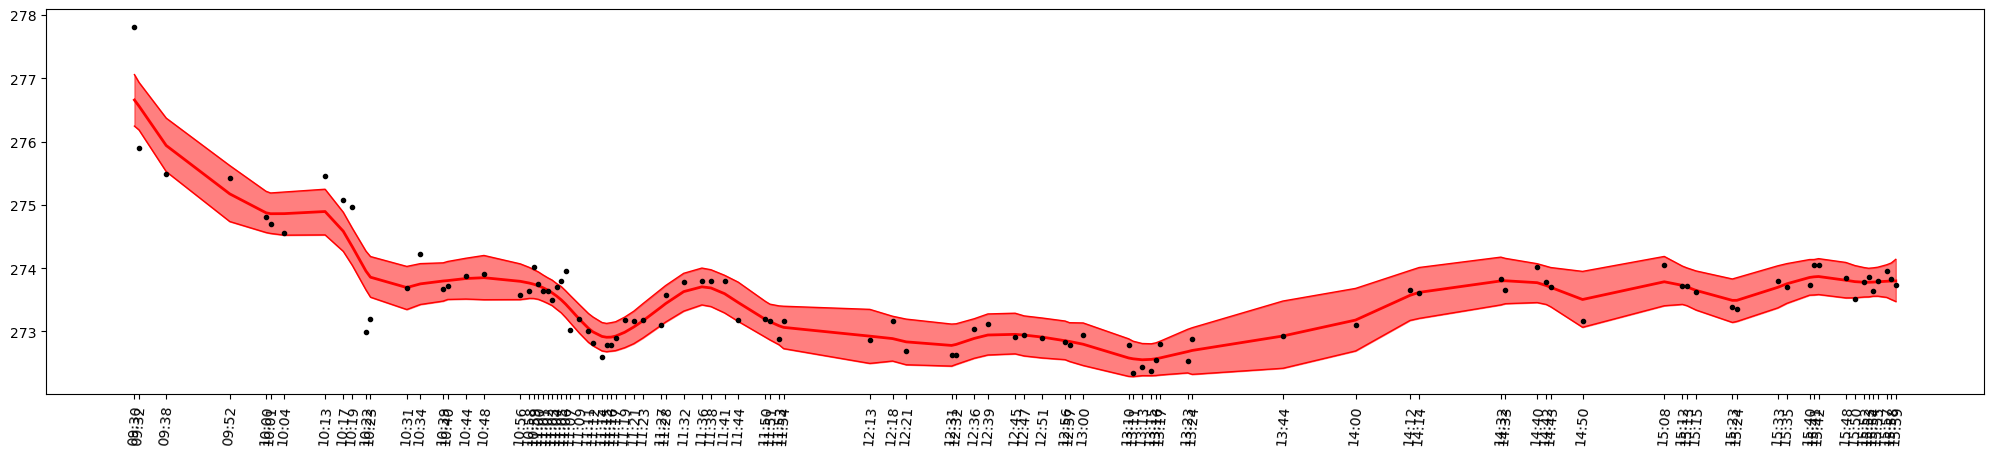

In [12]:
plt.figure(figsize=(25,5))
plt.plot(X, gp_median, "r", lw=2, label="mean and 2σ region")
plt.plot(X, gp_hdi_upper, "r", lw=1)
plt.plot(X, gp_hdi_lower, "r", lw=1)
plt.fill_between(X.T[0], gp_hdi_lower, gp_hdi_upper, color="r", alpha=0.5)
plt.locator_params(axis='x', nbins=10)
plt.xticks(X.T[0], labels=morn_price.index.strftime("%H:%M"), rotation=85)

plt.plot(X, morn_price.values, "ok", ms=3, alpha=1.0, label="observed data")

We can take this purely statistical model for our data, and improve upon it with econometric theory. For example, bid-ask bounce effects might be present in our data because of nonsynchronous trading.

Roll's model for the bid-ask spread is

$P_t = P_t^* + I_t \frac{s}{2}$,

$I_t = p * 1 + (1-p) * -1$,

where $P_t$ is the observed price, $P_t^*$ is the unobserved fundamental price, $s$ is the spread and $I_t$ is an indicator variable that assumes the values $1$ or $-1$ with 50% probability each. We can incorporate this structure into our Gaussian process model and estimate the bid-ask spread

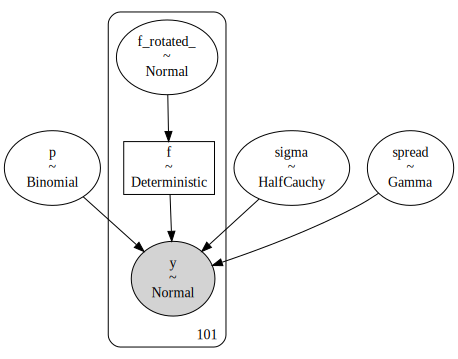

In [13]:
with pm.Model() as gp_model_roll:
    
    s = pm.Gamma("spread", 2, 5)
    p = pm.Binomial("p", n=1, p=0.5)
    
    I = p * 1 + (1-p) * -1
    
    mean_f = pm.gp.mean.Constant(np.mean(morn_price.values))
    lengthscale = 1
    cov = 2 * pm.gp.cov.Matern32(1, lengthscale)
    gp = pm.gp.Latent(mean_func = mean_f, cov_func=cov)

    f = gp.prior("f", X=X) + (I * (s/2))

    obs_noise = pm.HalfCauchy("sigma", beta = 0.1)
    y = pm.Normal("y", mu = f, sigma = obs_noise, observed = morn_price.values)
pm.model_to_graphviz(gp_model_roll)

In [14]:
with gp_model_roll:
    trace_roll = pm.sample(5000, tune=2000, target_accept=0.9, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [spread, f_rotated_, sigma]


>Metropolis: [p]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 606 seconds.


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [15]:
roll_median = np.median(trace_roll.posterior['f'].values, axis=(0,1)) # median across chains and draws 
roll_hdi_lower = az.hdi(trace_roll, hdi_prob=.95)['f'].T[0].values
roll_hdi_upper = az.hdi(trace_roll, hdi_prob=.95)['f'].T[1].values

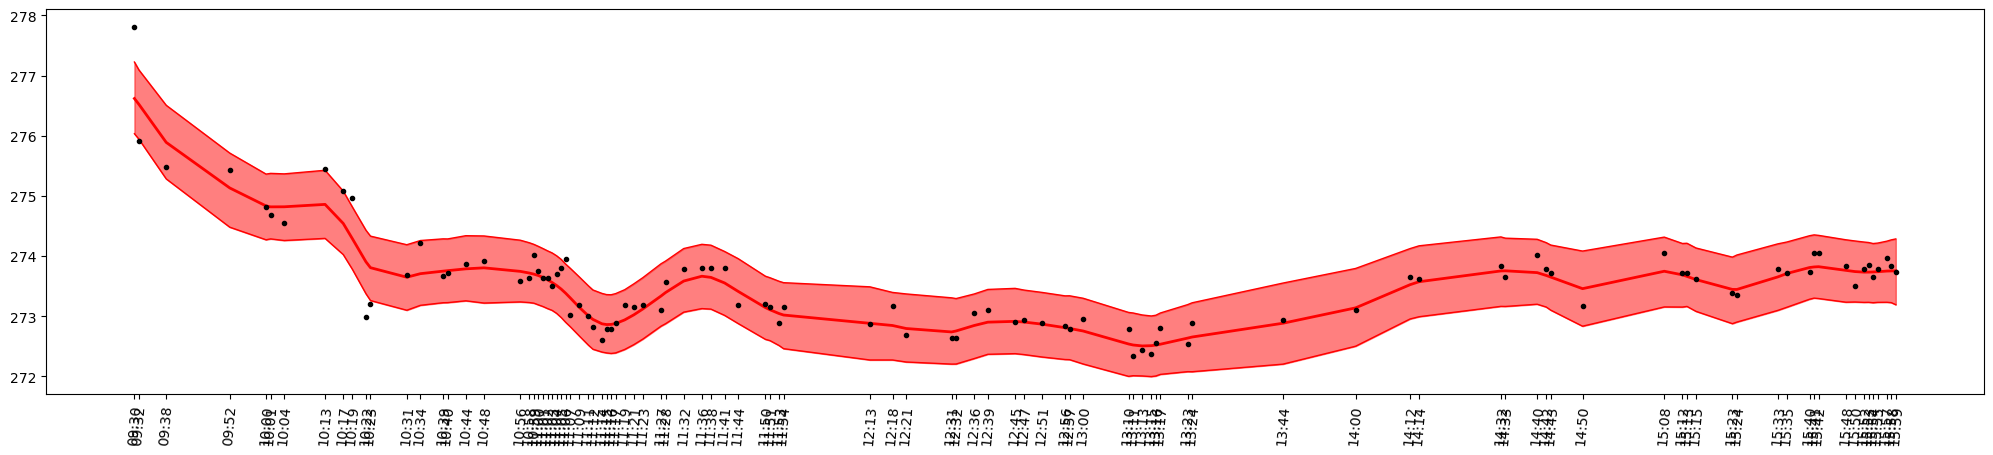

In [16]:
plt.figure(figsize=(25,5))
plt.plot(X, roll_median, "r", lw=2, label="mean and 2σ region")
plt.plot(X, roll_hdi_upper, "r", lw=1)
plt.plot(X, roll_hdi_lower, "r", lw=1)
plt.fill_between(X.T[0], roll_hdi_lower, roll_hdi_upper, color="r", alpha=0.5)
plt.locator_params(axis='x', nbins=10)
plt.xticks(X.T[0], labels=morn_price.index.strftime("%H:%M"), rotation=85)

plt.plot(X, morn_price.values, "ok", ms=3, alpha=1.0, label="observed data")

array([[<Axes: title={'center': 'spread'}>,
        <Axes: title={'center': 'spread'}>]], dtype=object)

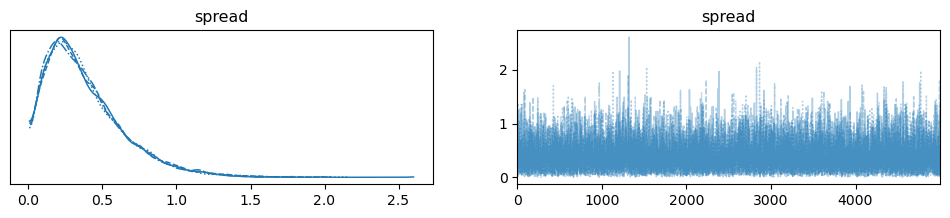

In [17]:
az.plot_trace(trace_roll, var_names=["spread"])

# Calculation of dynamic VaR/ES with stochastic volatility from the posterior predictive distribution

Value at risk (VaR) and expected shortfall (ES) are standard measures of risk for financial assets/portfolios. The former is the worst possible loss at a confidence level $\alpha$ (e.g. 95%) and the latter is the mean loss given that one of the $1 - \alpha$ worst outcomes has happened.

VaR and ES can be obtained from historical returns or parametric/Monte Carlo approaches, and most common implementations assume constant volatility over time. Using Bayesian methods we can fit a model with time-varying volatility to the historical returns data, and see how VaR/ES changes along time.

Stochastic volatility (SV) models are a type of state space model, where the volatility is a latent variable. As the volatility is the standard deviation of returns, and it can never assume negative values, a SV model has the general specification

$y_t \sim N(0, \exp \{ v_t \})$,

$v_t = v_{t-1} + \varepsilon_t$,

where $y_t$ are the returns and $v_t$ is known as the log-volatility. The functional form for the log-volatility above is a random walk, but other processes can also be used.

Let's try fitting a SV model where the log-volatility follows a random walk to a series of returns

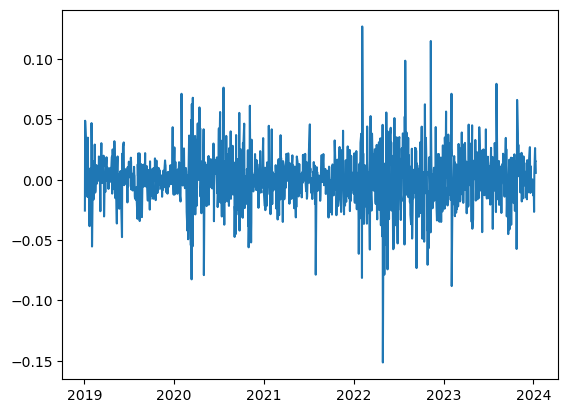

In [18]:
amzn_price = yf.Ticker("AMZN").history(start = "2019-01-01")["Close"]
amzn_returns = amzn_price.apply(np.log).diff().dropna()
plt.plot(amzn_returns)

C:\Users\USUARIO\anaconda3\envs\pymc_env\lib\site-packages\pymc\distributions\timeseries.py:293: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


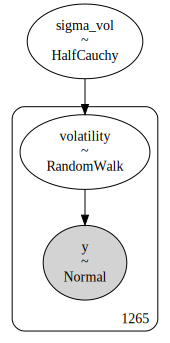

In [19]:
with pm.Model() as bayesian_sv:
    sigma_vol = pm.HalfCauchy("sigma_vol", 1)
    volatility = pm.GaussianRandomWalk("volatility", sigma = sigma_vol, shape = len(amzn_returns))
    
    y = pm.Normal("y", mu = 0, sigma = pm.math.exp(volatility), observed = amzn_returns.values)
pm.model_to_graphviz(bayesian_sv)

In [20]:
with bayesian_sv:
    trace_sv = pm.sample(5000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [sigma_vol, volatility]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 944 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Text(0.5, 1.0, 'Median posterior volatility')

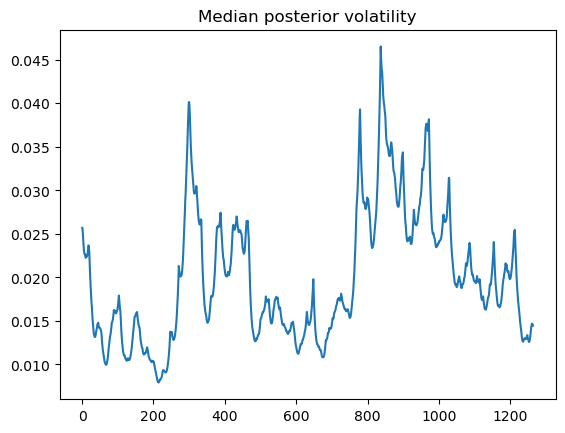

In [21]:
vol_median = np.median(trace_sv.posterior['volatility'].values, axis=(0,1)) # median across chains and draws 
plt.plot(np.exp(vol_median))
plt.title("Median posterior volatility")

array([[<Axes: title={'center': 'sigma_vol'}>,
        <Axes: title={'center': 'sigma_vol'}>]], dtype=object)

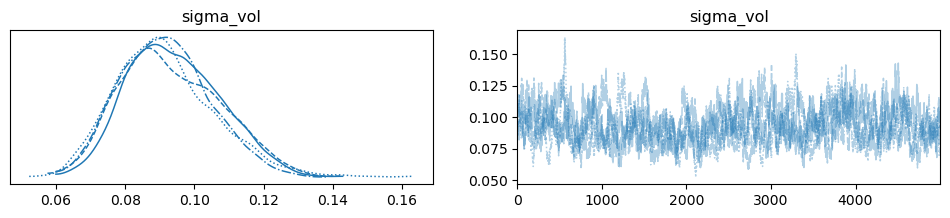

In [22]:
az.plot_trace(trace_sv, var_names=["~volatility"])

Now, instead of a random walk, we can try to specify the log-volatility process as an AR(1), which is common in the literature (https://dspace.cuni.cz/bitstream/handle/20.500.11956/40737/DPTX_2010_2__0_323248_0_111009.pdf?sequence=1)

C:\Users\USUARIO\anaconda3\envs\pymc_env\lib\site-packages\pymc\distributions\timeseries.py:558: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(


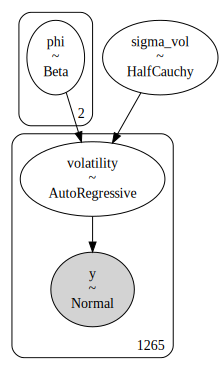

In [23]:
with pm.Model() as bayesian_sv_ar:
    phi = pm.Beta("phi", 1, 1, shape = 2)
    
    sigma_vol = pm.HalfCauchy("sigma_vol", 1)
    volatility = pm.AR("volatility", rho = phi, sigma = sigma_vol, constant=True, shape = len(amzn_returns))

    y = pm.Normal("y", mu = 0, sigma = np.exp(volatility), observed = amzn_returns.values)
pm.model_to_graphviz(bayesian_sv_ar)

In [24]:
with bayesian_sv_ar:
    trace_sv_ar = pm.sample(5000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [phi, sigma_vol, volatility]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 913 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Text(0.5, 1.0, 'Median posterior volatility')

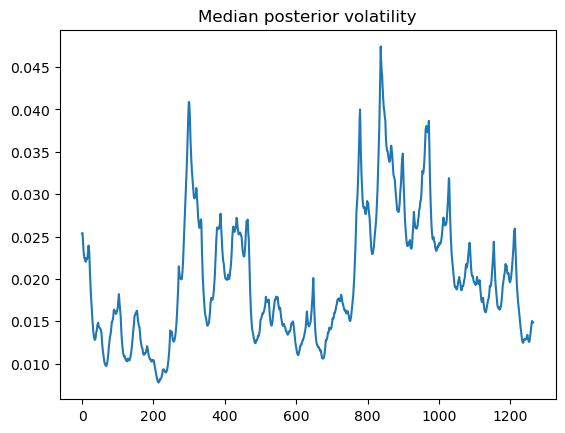

In [25]:
vol_median = np.median(trace_sv_ar.posterior['volatility'].values, axis=(0,1)) # median across chains and draws 
plt.plot(np.exp(vol_median))
plt.title("Median posterior volatility")

array([[<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>],
       [<Axes: title={'center': 'sigma_vol'}>,
        <Axes: title={'center': 'sigma_vol'}>]], dtype=object)

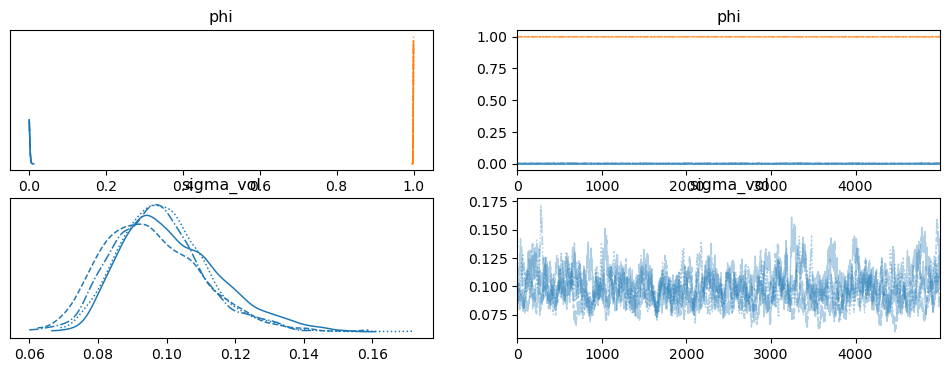

In [26]:
az.plot_trace(trace_sv_ar, var_names=["~volatility"])

It seems our AR coefficient (orange) heavily tends towards 1, which can be interpreted as evidence that the random walk assumption for our log-volatility seems valid.

We can try to specify models with jumps for the returns. Jumps are discrete changes at specific time periods, and can emulate movements such as the market reacting to new information. Statistical models for jumps generally have two components: the jump size and an indicator variable of whether a jump has happened or not.

A possible specification for jumps (https://joshuachan.org/papers/energy_GARCH_SV.pdf) is $q_t k_t$, where $q_t$ is a binary outcome variable (0 or 1) representing whether a jump happens or not at that period (with probability $\pi$), and $k_t$ is the size of the jump.

C:\Users\USUARIO\anaconda3\envs\pymc_env\lib\site-packages\pymc\distributions\timeseries.py:293: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


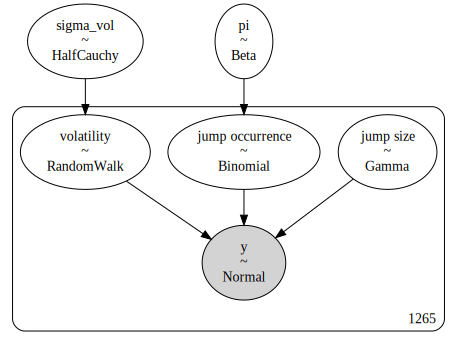

In [27]:
with pm.Model() as bayesian_sv_jump:
    sigma_vol = pm.HalfCauchy("sigma_vol", 1)
    volatility = pm.GaussianRandomWalk("volatility", sigma = sigma_vol, shape = len(amzn_returns))
        
    pi = pm.Beta('pi', 1, 1)
    jump_size = pm.Gamma("jump size", 2, 5, shape=len(amzn_returns))
    jump_occ = pm.Binomial("jump occurrence", p=pi, n=1, shape=len(amzn_returns))
    jump = jump_size * jump_occ

    y = pm.Normal("y", mu = jump, sigma = pm.math.exp(volatility), observed = amzn_returns.values)
pm.model_to_graphviz(bayesian_sv_jump)

In [28]:
with bayesian_sv_jump:
    trace_sv_jump = pm.sample(5000, tune=2000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [sigma_vol, volatility, pi, jump size]


>Metropolis: [jump occurrence]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 5801 seconds.


C:\Users\USUARIO\anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Text(0.5, 1.0, 'Median posterior volatility')

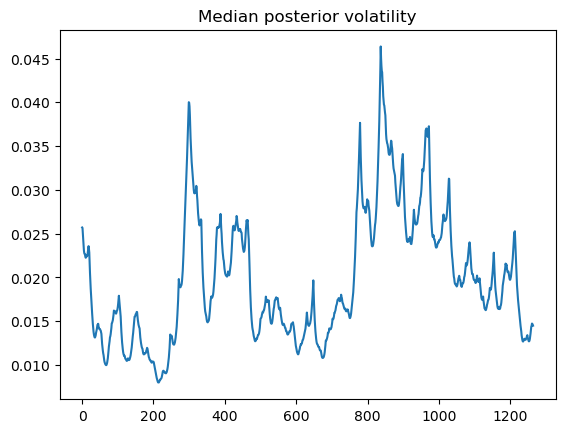

In [29]:
vol_median = np.median(trace_sv_jump.posterior['volatility'].values, axis=(0,1)) # median across chains and draws 
plt.plot(np.exp(vol_median))
plt.title("Median posterior volatility")

array([[<Axes: title={'center': 'jump occurrence'}>,
        <Axes: title={'center': 'jump occurrence'}>],
       [<Axes: title={'center': 'sigma_vol'}>,
        <Axes: title={'center': 'sigma_vol'}>],
       [<Axes: title={'center': 'pi'}>, <Axes: title={'center': 'pi'}>]],
      dtype=object)

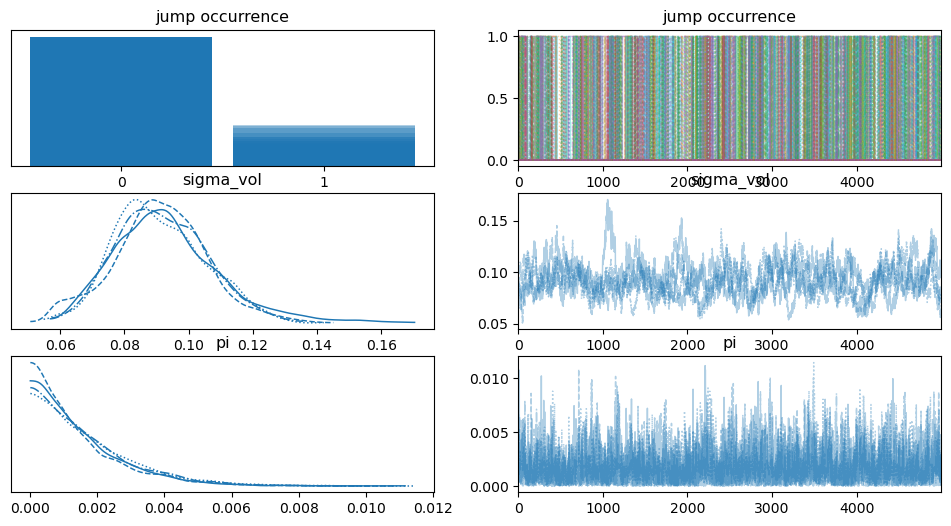

In [30]:
az.plot_trace(trace_sv_jump, var_names=["~volatility",'~jump size'])

The estimated jump probability (pi) tends heavily towards zero, so we conclude that including jumps did not provide significant gains for our model.

Lastly, Bayesian computation also allows us to specify the returns as coming from a t distribution, so we can also try that and assign a prior to the degrees of freedom parameter.

C:\Users\USUARIO\anaconda3\envs\pymc_env\lib\site-packages\pymc\distributions\timeseries.py:293: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


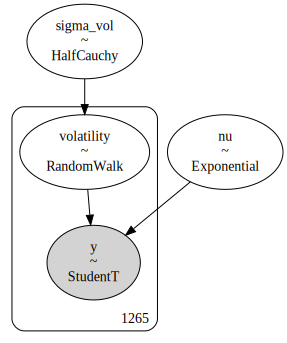

In [31]:
with pm.Model() as bayesian_sv_tdist:
    sigma_vol = pm.HalfCauchy("sigma_vol", 1)
    volatility = pm.GaussianRandomWalk("volatility", sigma = sigma_vol, shape = len(amzn_returns))

    nu = pm.Exponential('nu', 1)
    y = pm.StudentT("y", nu=nu, mu = 0, sigma = pm.math.exp(volatility), observed = amzn_returns.values)
pm.model_to_graphviz(bayesian_sv_tdist)

In [32]:
with bayesian_sv_tdist:
    trace_sv_tdist = pm.sample(5000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [sigma_vol, volatility, nu]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 1767 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Text(0.5, 1.0, 'Median posterior volatility')

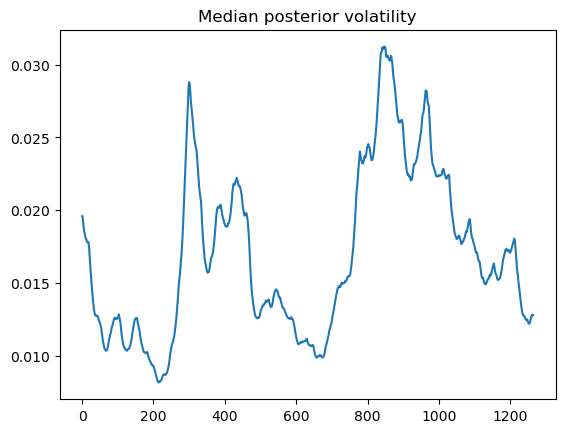

In [33]:
vol_median = np.median(trace_sv_tdist.posterior['volatility'].values, axis=(0,1)) # median across chains and draws 
plt.plot(np.exp(vol_median))
plt.title("Median posterior volatility")

array([[<Axes: title={'center': 'sigma_vol'}>,
        <Axes: title={'center': 'sigma_vol'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>]],
      dtype=object)

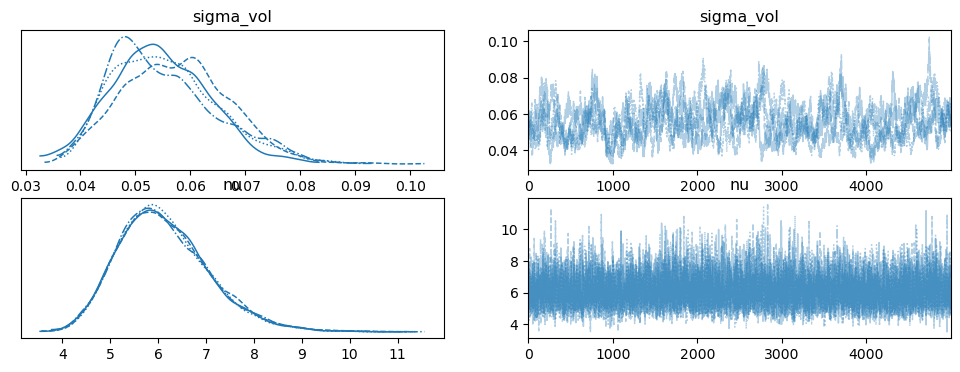

In [34]:
az.plot_trace(trace_sv_tdist, var_names=["~volatility"])

Now that we have a few stochastic models at hand, we can pick one to calculate our value-at-risk/expected shortfall from. For example purposes, we shall pick the t distribution model.

Remember the Bayesian inference procedure for parameter(s) $\theta$ and a set of data $y$:

$P(\theta|y) = \frac{P(\theta)P(y|\theta)}{P(y)}$.

A Bayesian model is defined as the joint distribuion of the data and all parameters. This means that, not only we can find the posterior distribution of the parameters given the priors and a set of data, we can also use the posterior obtained from a first set of data to sample unobserved future sets of data from the model. The distribution of possible future values of data given the posterior from a previous set of data is known as the *posterior predictive* distribution. 

Given a first set of data $y$, a future set of data $\tilde{y}$ can be obtained as

$P(\tilde{y}|y) = \int_\Theta P(\tilde{y}|\theta,y)P(\theta|y)d\theta$,

which is a marginalization over the parameter(s) $\theta$.

We can use our model to generate a set of posterior predictive data

In [35]:
with bayesian_sv_tdist:
    trace_sv_tdist.extend(pm.sample_posterior_predictive(trace_sv_tdist))
sv_ppd = trace_sv_tdist.posterior_predictive.stack(pooled_chain=("chain", "draw"))
pp_returns = sv_ppd.y.values

Sampling: [y]


The posterior predictive simulation generates 20000 samples for each period of our time series of returns. We can then calculate VaR and ES for the 20000 samples at each time period in order to obtain a dynamic VaR/ES

Text(0.5, 1.0, 'Posterior predictive VaR and ES')

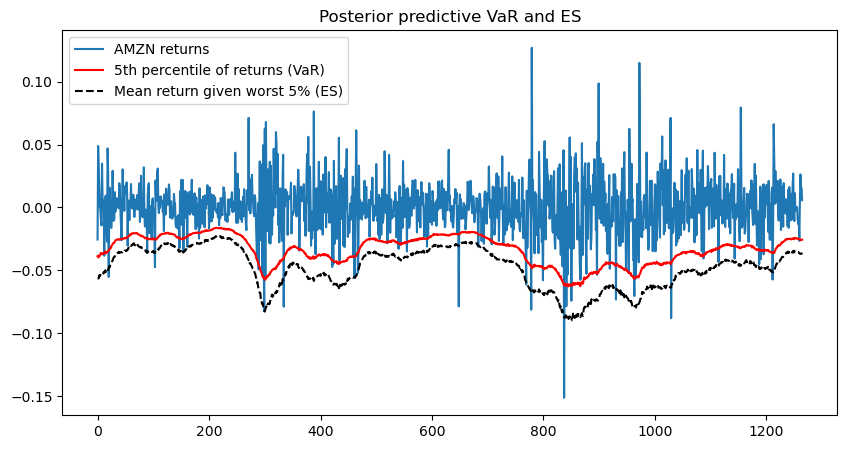

In [36]:
conf_level = 0.95
var = np.quantile(pp_returns, 1 - conf_level, axis=1)
es = np.empty(len(amzn_returns))
for i in range(0,len(amzn_returns)):
    tail = pp_returns[i][(pp_returns[i] < np.quantile(pp_returns[i], 1 - conf_level))]
    mean_tail = np.mean(tail)
    es[i] = mean_tail

plt.figure(figsize=(10,5))
plt.plot(amzn_returns.values, label="AMZN returns")
plt.plot(var, color="r", label="5th percentile of returns (VaR)")
plt.plot(es, color="k", linestyle="dashed", label="Mean return given worst 5% (ES)")
plt.legend()
plt.title("Posterior predictive VaR and ES")

We can compare this dynamic VaR/ES obtained from the model with t-distributed returns and stochastic volatility to that of a model with normally distributed returns and constant volatility

In [37]:
with pm.Model() as normal_const_vol:
    volatility = pm.HalfCauchy("volatility", 1)
    y = pm.Normal('y', mu = 0, sigma = volatility, observed = amzn_returns.values)

with normal_const_vol:
    trace_normal_cv = pm.sample(5000, tune=2000, return_inferencedata=True)
    trace_normal_cv.extend(pm.sample_posterior_predictive(trace_normal_cv))
nc_ppd = trace_normal_cv.posterior_predictive.stack(pooled_chain=("chain", "draw"))
pp_returns_nc = nc_ppd.y.values

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [volatility]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 50 seconds.


Sampling: [y]


Text(0.5, 1.0, 'VaR and ES: t + SV vs. Normal')

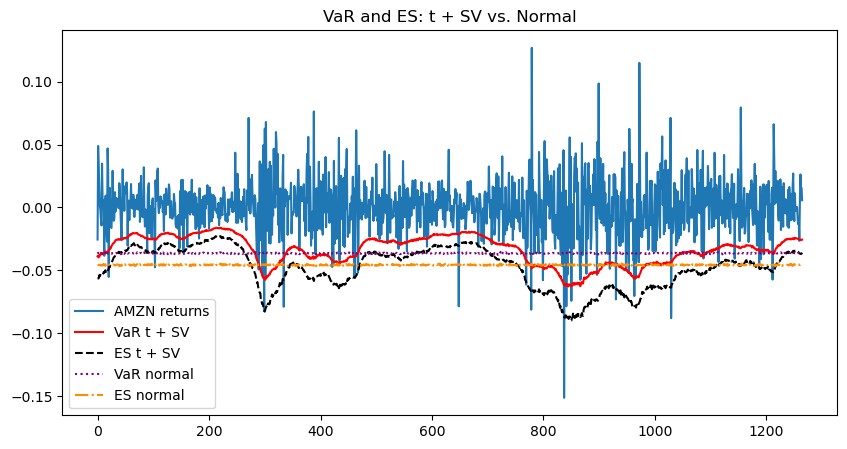

In [38]:
conf_level = 0.95
var_nc = np.quantile(pp_returns_nc, 1 - conf_level, axis=1)
es_nc = np.empty(len(amzn_returns))
for i in range(0,len(amzn_returns)):
    tail = pp_returns_nc[i][(pp_returns_nc[i] < np.quantile(pp_returns_nc[i], 1 - conf_level))]
    mean_tail = np.mean(tail)
    es_nc[i] = mean_tail

plt.figure(figsize=(10,5))
plt.plot(amzn_returns.values, label="AMZN returns")
plt.plot(var, color="r", label="VaR t + SV")
plt.plot(es, color="k", linestyle="dashed", label="ES t + SV")
plt.plot(var_nc, color="purple", linestyle="dotted", label="VaR normal")
plt.plot(es_nc, color="darkorange", linestyle="dashdot", label="ES normal")
plt.legend()
plt.title("VaR and ES: t + SV vs. Normal")

For the normal model, the VaR/ES is constant because the posterior predictive returns at each time are sampled from a distribution with constant volatility. This can underestimate risk at high volatility periods and superestimate risk at low volatility periods.

## Additional references for this section

Gaussian Processes for Time Series Forecasting with PyMC by Juan Orduz: https://juanitorduz.github.io/gp_ts_pymc3/.

Campbell, John Y., Andrew W. Lo, and A. Craig MacKinlay. The Econometrics of Financial Markets. Princeton University Press, 1997.

Roll, Richard. "A Simple Implicit Measure of the Effective Bid-Ask Spread in an Efficient Market" The Journal of Finance 39-4 (1984): 1127-1139.

Tesarova, Viktoria. "Value at Risk: GARCH vs. Stochatistic Volatility Models: Empirical Study." (2013).

Chan, Joshua CC, and Angelia L. Grant. "Modeling energy price dynamics: GARCH versus stochastic volatility." Energy Economics 54 (2016): 182-189.